In [1]:
%pip install google-cloud-firestore

    100% |████████████████████████████████| 337kB 2.7MB/s ta 0:00:01
    100% |████████████████████████████████| 71kB 1.7MB/s ta 0:00:011
    100% |████████████████████████████████| 81kB 9.4MB/s eta 0:00:01
    100% |████████████████████████████████| 1.4MB 2.7MB/s ta 0:00:01
    100% |████████████████████████████████| 2.1MB 1.2MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 866kB/s ta 0:00:01
    100% |████████████████████████████████| 81kB 1.8MB/s ta 0:00:011
  Running setup.py bdist_wheel for googleapis-common-protos ... done
  Stored in directory: /Users/kamil/Library/Caches/pip/wheels/9e/3d/a2/1bec8bb7db80ab3216dbc33092bb7ccd0debfb8ba42b5668d5
Successfully built googleapis-common-protos
google-auth 1.7.0 has requirement setuptools>=40.3.0, but you'll have setuptools 39.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to res

# Parse data from Firestore

In [89]:
from google.cloud import firestore
from google.oauth2 import service_account
from datetime import datetime
import dateutil.parser

credentials = service_account.Credentials.from_service_account_file(
    'api-key.json',
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

db = firestore.Client(
    credentials=credentials,
    project=credentials.project_id)

def parse_installations(ids = None):
    installations = list(db.collection('installations').list_documents())
    installations_flat = {}

    for installation in installations:
        inst_id = int(installation.id.replace("_", ""))
        if ids is None or inst_id in ids:
            measurements = installation.collection('measurements').stream()
            measurements_flat = {}
            for measurement in measurements:
                for record in measurement.to_dict()['history']:
                    date = dateutil.parser.parse(record['fromDateTime'])
                    measurements_flat[date] = record
            installations_flat[inst_id] = measurements_flat
    return installations_flat

installations = parse_installations()

# Plot single installation metrics in given range

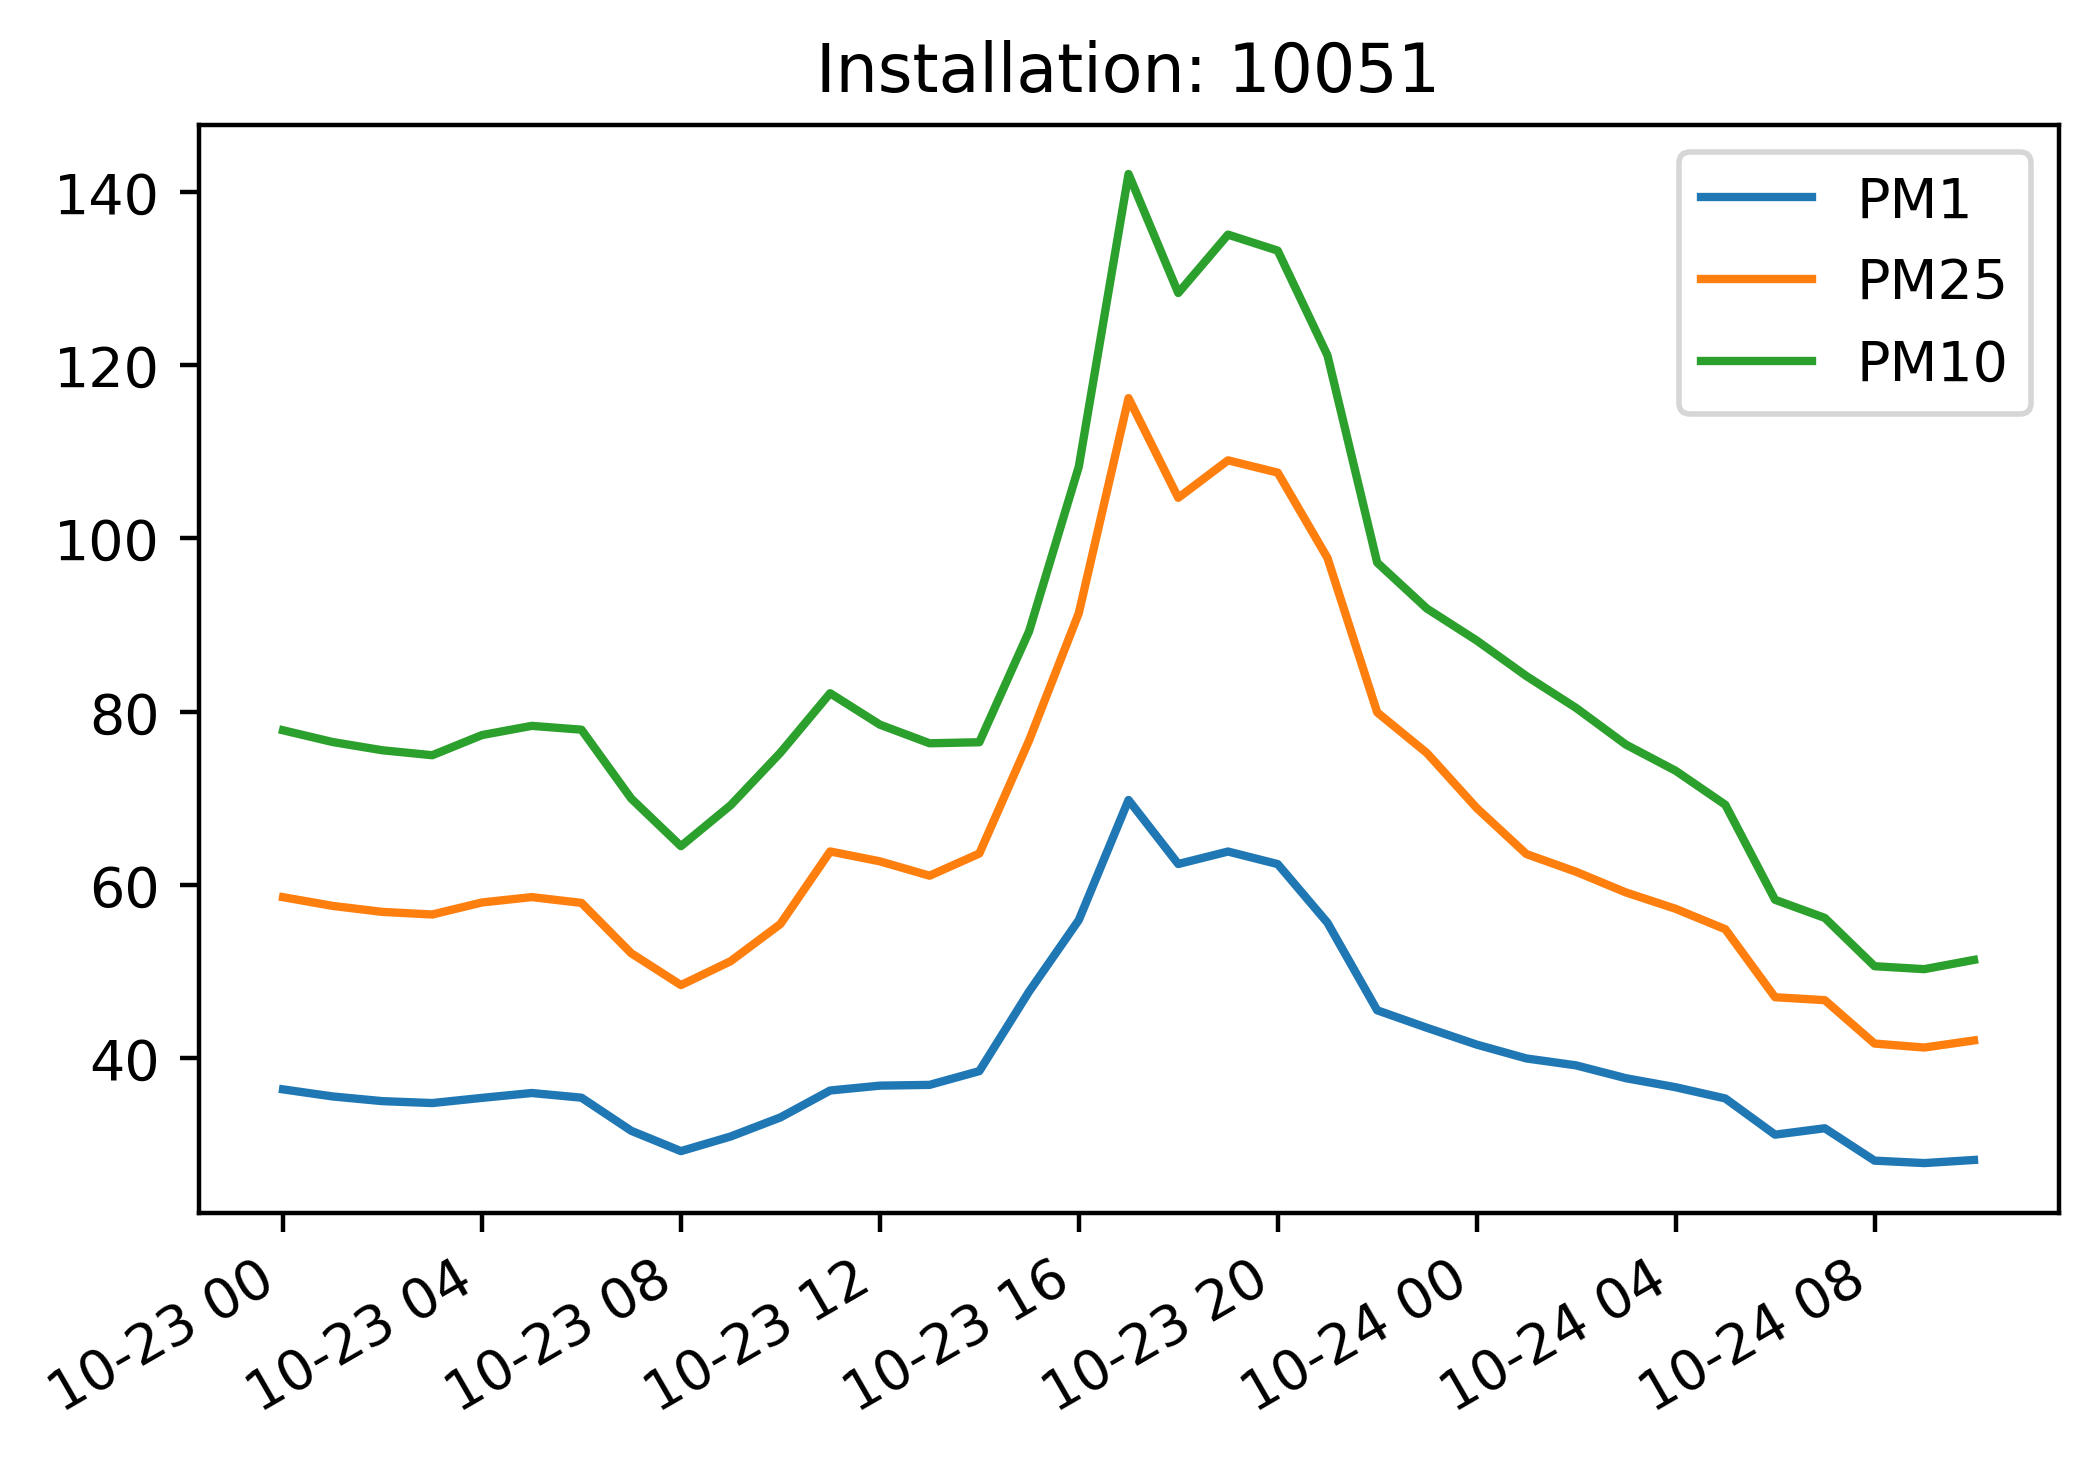

In [90]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import dates as dat
from datetime import datetime, timezone
import numpy as np

plt.rcParams['figure.dpi'] = 200

def plot_metrics_for_installation(installations, installation_id, metrics, start=None, end=None):
    datetimes = []
    values = {}
    for (key, value) in sorted(installations[installation_id].items(), key=lambda k: k[0]):
        if set(metrics).issubset(set(map(lambda val: val['name'], value['values']))):
            if (start is None or start <= key) and (end is None or end >= key):
                datetimes.append(key)
                for v in value['values']:
                    if v['name'] in metrics:
                        val_list = values.get(v['name'], [])
                        val_list.append(v['value']) 
                        values[v['name']] = val_list

    for (key, serie) in values.items():
        plt.plot(datetimes, serie, label=key)

    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.title('Installation: {}'.format(installation_id))
    plt.show()

start_date = datetime(2019, 10, 23, 0, 0, 0, tzinfo=timezone.utc)
end_date = datetime(2019, 10, 24, 10, 0, 0, tzinfo=timezone.utc)
plot_metrics_for_installation(installations, 10051, ['PM1', 'PM10', 'PM25'], start_date, end_date)

# Plot averaged metrics

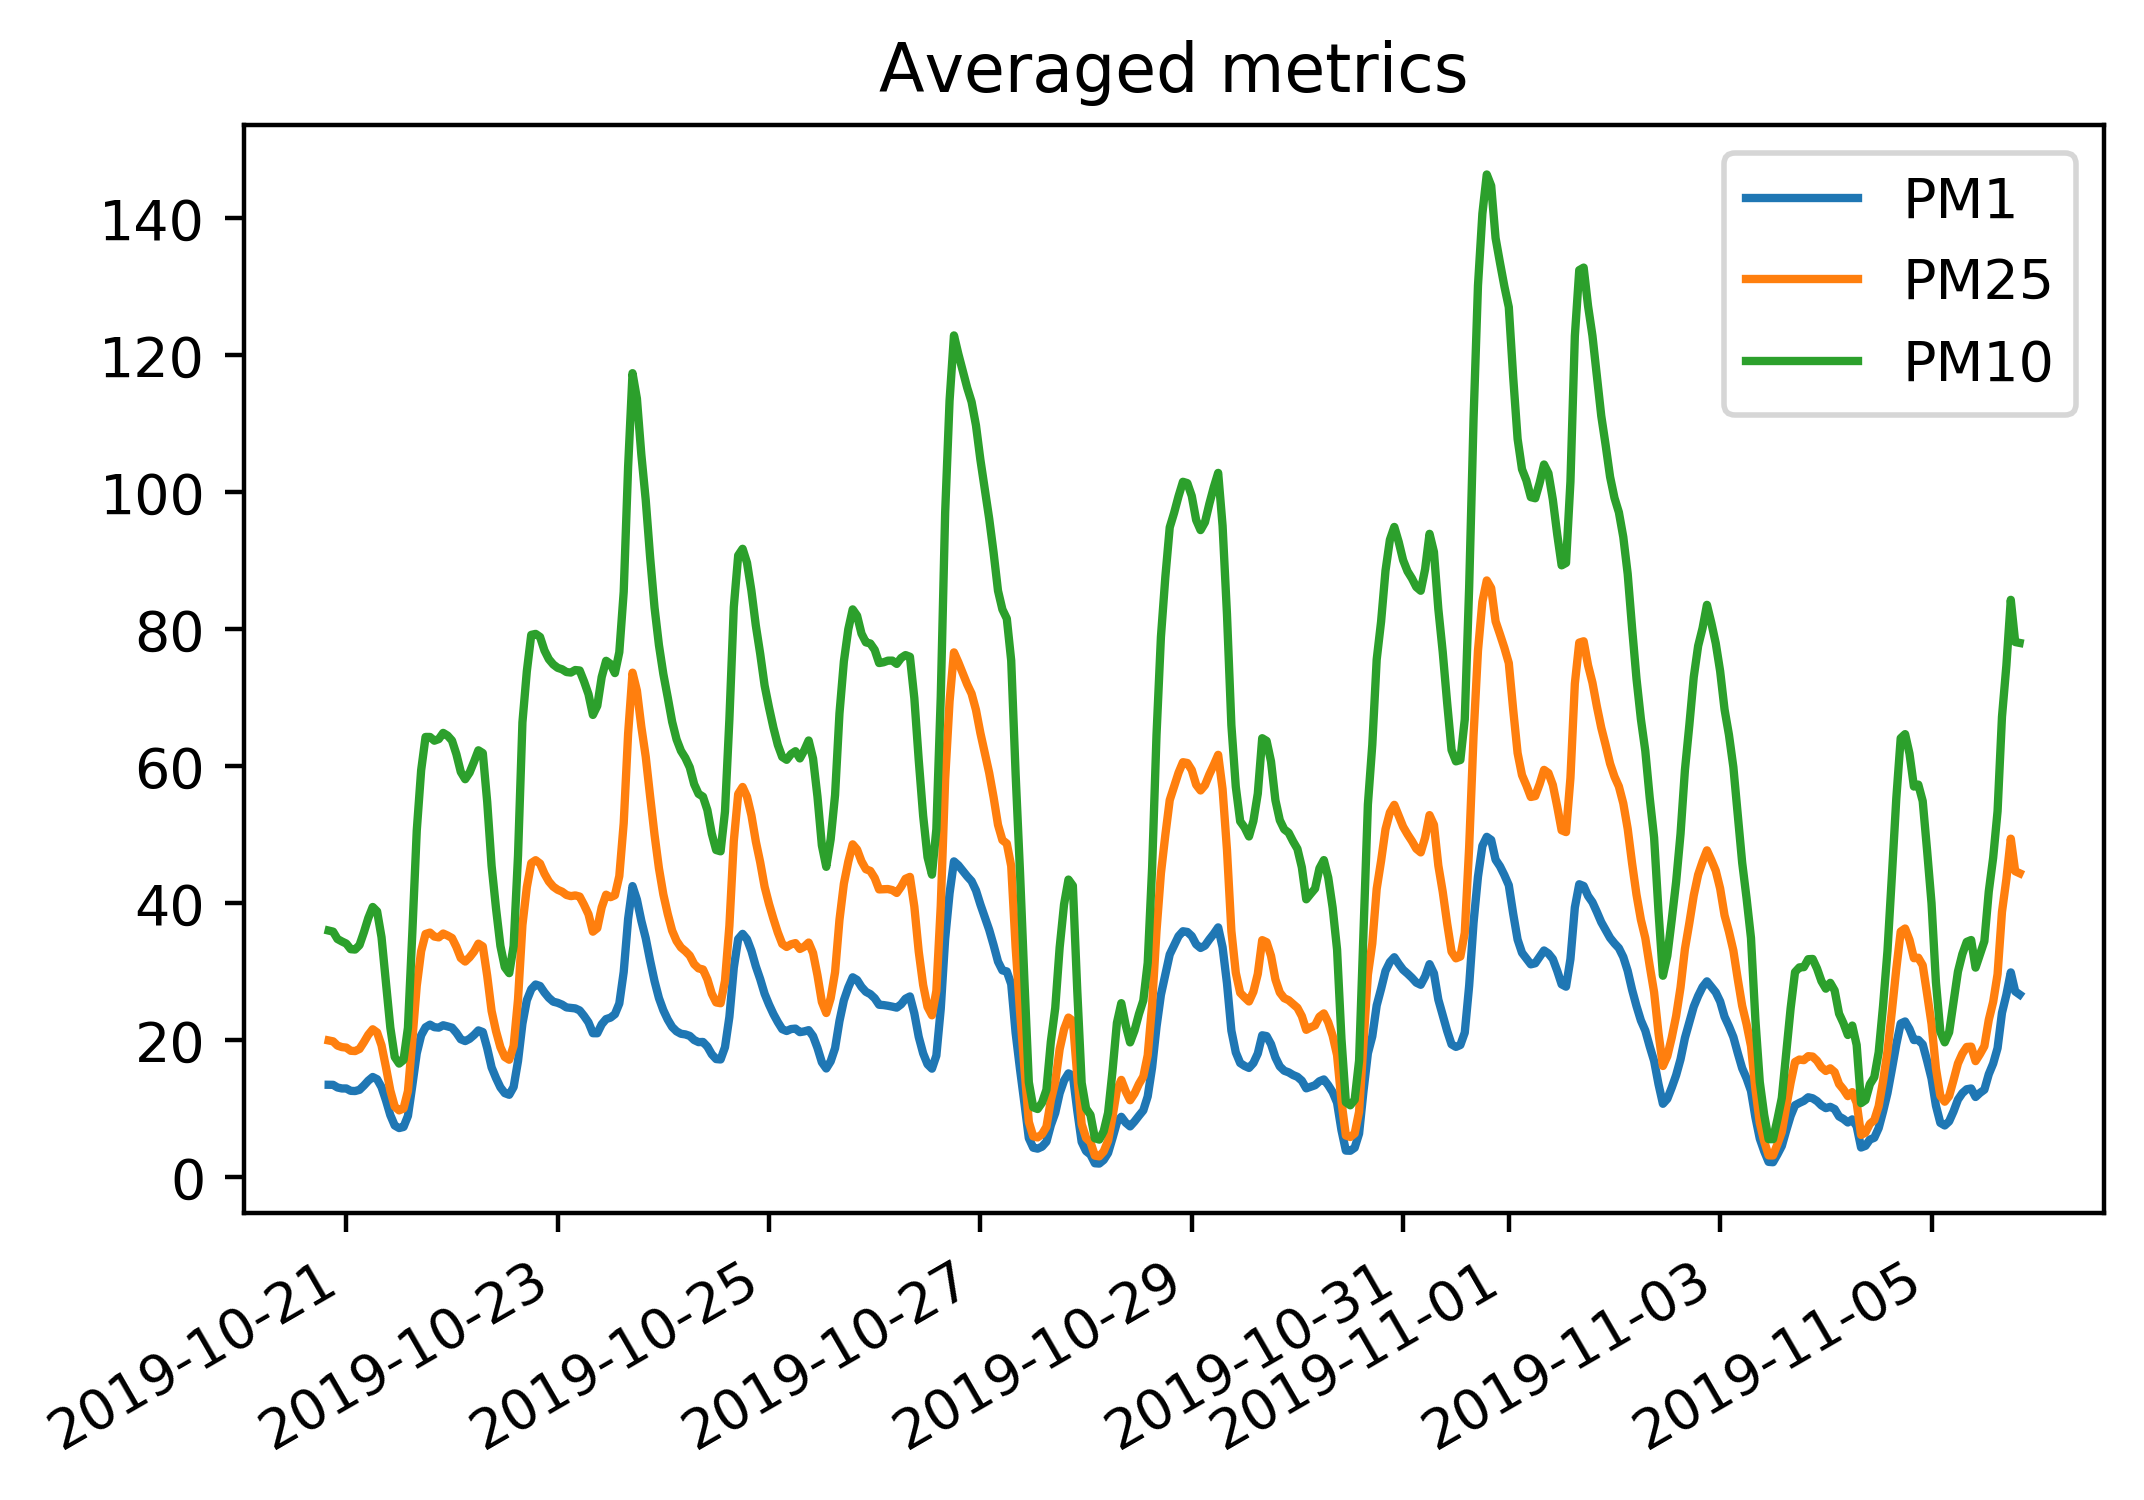

In [98]:
from functools import reduce

def plot_averaged_metrics(installations, metrics, start=None, end=None):
    values = {}
    for inst in installations.values():
        for (key, value) in sorted(inst.items(), key=lambda k: k[0]):
            if set(metrics).issubset(set(map(lambda val: val['name'], value['values']))):
                if (start is None or start <= key) and (end is None or end >= key):
                    datetime_values = values.get(key, {})
                    for v in value['values']:
                        if v['name'] in metrics:
                            val_list = datetime_values.get(v['name'], [])
                            val_list.append(v['value']) 
                            datetime_values[v['name']] = val_list
                    values[key] = datetime_values

    series = {}
    datetimes = []
    for (time, metr) in values.items():
        datetimes.append(time)
        for (met_key, met_values) in metr.items():
            met_list = series.get(met_key, [])
            met_list.append(reduce(lambda a,b: a+b, met_values) / len(met_values))
            series[met_key] = met_list
    
    for (key, serie) in series.items():
        plt.plot(datetimes, serie, label=key)

    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.title('Averaged metrics')
    plt.show()
    
plot_averaged_metrics(installations, ['PM1', 'PM10', 'PM25'])
    